## Measuring Neighbourhood Change with OLS

Loading in the preliminaries

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely
import pysal
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [5]:
df = pd.read_csv("data/all_data_2016_CTs_V3.csv", dtype={'ctuid': str})
df["w"] = np.log(0.1 * df["h_n_hhld"] + 1) # weight field

df = df[(df["cma"] == 535)]

dfses = pd.read_csv("data/PCA_SES_Toronto.csv")

df = pd.merge(df,dfses,on = "ct_year", how = "left")

/home/jamaps/miniconda3/envs/map/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


4.756658553821811


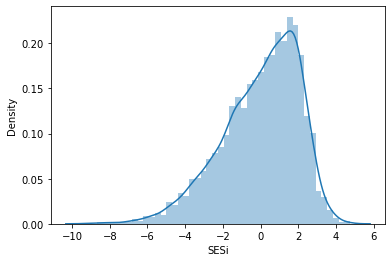

In [6]:
sns.distplot(df["SESi"]);

print(df["SESi"].max())

This code computes rates of change of a variable in a neighbourhood (census tract) over time. e.g. average rate of change in population in a neighbourhood from 1991 to 2016

In [9]:
# output setup
dfo = pd.DataFrame(df.ctuid.unique())
dfo.columns = ['ctuid']
dfo

# accessibility and SES models
variables = [
    'Ai_jobs_transit',
    'Ai_activities_transit',
    'Ai_jobs_auto',
    'Ai_activities_auto',
    'Ai_jobs_ratio',
    'Ai_activities_ratio',
    'Ai_combine',
    'SESi',
    'inc_avg_inc_16',
    'pop',
    "dw",
    
    "pop_elderly_prop",
    "pop_child_prop",
    "pop_immig",
    "pop_nodegree",
    "pop_unemployed",
    "inc_lico_p",
    "inc_total30p",
    "dw_majorrep",
    "dw_lone_prop",
    "dw_no_car",
]
for variable in variables:
    output = []
    out_row = {"ctuid": "x", variable + "_beta": 0}
    output.append(out_row)
    for ctuid in (df.ctuid.unique()):
        try:
            temp = df[[ 'ctuid','year',variable]]
            temp = temp.loc[(temp.ctuid == ctuid)]
            temp = temp.dropna()
            
            x = temp["year"].values.reshape(len(temp), 1)
            y = temp[variable].values.reshape(len(temp), 1)
            reg = sklearn.linear_model.LinearRegression()
            reg.fit(x,y)
            beta = reg.coef_[0][0]

            # output data
            out_row = {
                "ctuid": ctuid,
                variable + "_beta": beta
            }
            output.append(out_row)
        except:
            out_row = {
                "ctuid": ctuid,
                variable + "_beta": 0
            }
            output.append(out_row)
            
    output = pd.DataFrame(output)
    dfo = dfo.merge(output, on='ctuid', how = 'outer')

    
# travel behaviour
variables = [
    ["mean_nonworktrip_time_adult","w"],
    ["mean_commute_time_adult","w"],
    ["R_activities_per_day","w"],
]
for variable in variables:
    output = []
    out_row = {"ctuid": "x",variable[0] + "_beta": 0}
    output.append(out_row)
    for ctuid in (df.ctuid.unique()):
        try:
            temp = df[[ 'ctuid','year',variable[0],variable[1] ]]
            temp = temp.loc[(temp.ctuid == ctuid)]
            temp = temp.dropna()
            temp["X"] = temp[variable[0]]

            x = temp["year"].values.reshape(len(temp), 1)
            y = temp["X"].values.reshape(len(temp), 1)
            w = temp["w"].values.reshape(len(temp), 1)
            reg = sklearn.linear_model.LinearRegression()
            reg.fit(x,y, sample_weight = temp["w"])
            beta = reg.coef_[0][0]

            # output data
            out_row = {
                "ctuid": ctuid,
                variable[0] + "_beta": beta
            }
            output.append(out_row)
        except:
            out_row = {
                "ctuid": ctuid,
                variable[0] + "_beta": 0
            }
            output.append(out_row)
    output = pd.DataFrame(output)
    dfo = dfo.merge(output, on='ctuid', how = 'outer')

In [10]:
dfo

,ctuid,Ai_jobs_transit_beta,Ai_activities_transit_beta,Ai_jobs_auto_beta,Ai_activities_auto_beta,Ai_jobs_ratio_beta,Ai_activities_ratio_beta,Ai_combine_beta,SESi_beta,inc_avg_inc_16_beta,...,pop_nodegree_beta,pop_unemployed_beta,inc_lico_p_beta,inc_total30p_beta,dw_majorrep_beta,dw_lone_prop_beta,dw_no_car_beta,mean_nonworktrip_time_adult_beta,mean_commute_time_adult_beta,R_activities_per_day_beta
0,5350001.00,0.002263,1419.214161,0.004042,8661.798427,0,0,0.002827,0.229580,2836.928571,...,-0.021092,-0.001995,-0.012332,-0.016082,0.003703,-0.009145,-0.009926,0.158825,-0.105972,0.012605
1,5350002.00,0.002867,1065.551821,0.004844,8678.036067,0,0,0.002686,0.068792,794.119771,...,-0.003081,0.000588,-0.001349,0.001736,-0.007152,-0.002103,0.017984,0.035890,0.335951,-0.026922
2,5350003.00,0.002633,1473.969160,0.004671,8360.527647,0,0,0.003073,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.009231,-0.007766,-0.085262,-0.280916,0.009802
3,5350004.00,0.005969,3009.486516,0.006937,9988.214900,0,0,0.006560,0.082948,311.912400,...,-0.007073,-0.003272,-0.000616,0.002351,-0.000375,0.000069,0.004310,-0.159557,-0.016199,0.001180
4,5350005.00,0.005969,3009.486516,0.006937,9988.214900,0,0,0.006560,0.131929,548.292457,...,-0.011510,-0.003467,-0.003496,0.004577,-0.002501,-0.002591,0.004310,-0.159066,-0.015446,0.001158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,5350830.00,0.001192,141.099155,-0.000797,2557.996776,0,0,0.000748,0.030756,1579.882443,...,-0.004584,-0.000431,0.000322,0.000837,-0.002113,0.001392,0.000403,-0.009235,-0.078871,0.003419
1130,5350831.01,0.000929,199.771206,-0.001196,1929.034600,0,0,0.000693,0.040077,2225.806514,...,-0.006618,0.000121,-0.000692,0.000154,-0.001170,0.001931,-0.000211,0.260519,0.328678,-0.012250
1131,5350831.02,0.001000,263.247419,-0.001295,2046.230138,0,0,0.000805,0.038935,1388.843714,...,-0.006124,-0.000648,-0.000369,-0.000194,-0.001024,0.001921,-0.000020,0.017225,-0.366863,0.003633
1132,5350832.00,0.000067,5.035771,0.000223,2089.258093,0,0,0.000038,-0.001151,1010.591200,...,-0.007353,0.000711,0.000106,0.000198,0.000679,0.002597,-0.001272,-0.030624,0.257758,0.005746


In [17]:
# write to csv (this is then used to link to boundaries in QGIS to make some maps!)
# dfo.to_csv("data/var_betas.csv")

Simple example of the final result

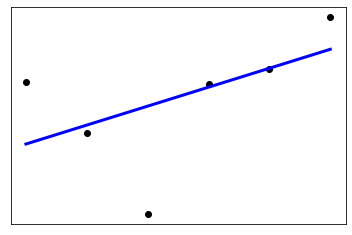

In [11]:
plt.scatter(x, y,  color='black')
plt.plot(x, reg.predict(x), color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

Exmining scatter plots for relationship between change in one variable compared to change in another, at this neighbourhood level (each dot is a neighbourhood, values represent slope over time)

<AxesSubplot:xlabel='Ai_combine_beta', ylabel='mean_commute_time_adult_beta'>

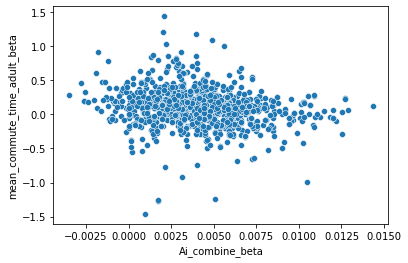

In [12]:
sns.scatterplot(x="Ai_combine_beta", y="mean_commute_time_adult_beta", data=dfo)

Correlatiaon matrix of a few key variables

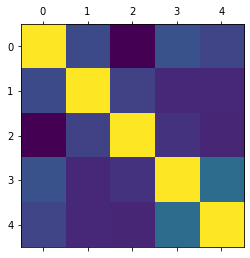

                              Ai_combine_beta  dw_no_car_beta  \
Ai_combine_beta                      1.000000        0.071270   
dw_no_car_beta                       0.071270        1.000000   
mean_commute_time_adult_beta        -0.197473        0.039634   
R_activities_per_day_beta            0.102987       -0.059159   
SESi_beta                            0.054923       -0.064759   

                              mean_commute_time_adult_beta  \
Ai_combine_beta                                  -0.197473   
dw_no_car_beta                                    0.039634   
mean_commute_time_adult_beta                      1.000000   
R_activities_per_day_beta                        -0.020950   
SESi_beta                                        -0.066690   

                              R_activities_per_day_beta  SESi_beta  
Ai_combine_beta                                0.102987   0.054923  
dw_no_car_beta                                -0.059159  -0.064759  
mean_commute_time_adult_beta 

In [16]:
import matplotlib.pyplot as plt

dfs = dfo[["Ai_combine_beta","dw_no_car_beta","mean_commute_time_adult_beta","R_activities_per_day_beta","SESi_beta"]]

plt.matshow(dfs.corr())
plt.show()
print(dfs.corr())
